# LSTM

We tried implementing an LSTM using pytorch for next basket item prediction with a LastFM dataset.

Dataset : https://github.com/eifuentes/lastfm-dataset-1K

### Imports and packages

In [1]:
#!pip install d2l==1.0.0a1.post0

In [2]:
%matplotlib inline
import csv
import glob
import re
import numpy as np
import scipy.io
import scipy.signal
import matplotlib.pyplot as plt
import torch
from d2l import torch as d2l

import os
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter


#!pip install fastparquet

## Dataset

In [3]:
df = pd.read_parquet('..\lastfm-dataset-1k.snappy.parquet')

In [4]:
df = df.dropna()

In [6]:
print(f'Number of Records: {len(df):,}\nUnique Users: {df.user_id.nunique()}\nUnique Artist:{df.artist_id.nunique():,}')
df.head()

Number of Records: 16,936,134
Unique Users: 992
Unique Artist:83,905


,user_id,timestamp,artist_id,artist_name,track_id,track_name
0,user_000001,2006-08-13 13:59:20+00:00,09a114d9-7723-4e14-b524-379697f6d2b5,Plaid & Bob Jaroc,c4633ab1-e715-477f-8685-afa5f2058e42,The Launching Of Big Face
1,user_000001,2006-08-13 14:03:29+00:00,09a114d9-7723-4e14-b524-379697f6d2b5,Plaid & Bob Jaroc,bc2765af-208c-44c5-b3b0-cf597a646660,Zn Zero
2,user_000001,2006-08-13 14:10:43+00:00,09a114d9-7723-4e14-b524-379697f6d2b5,Plaid & Bob Jaroc,aa9c5a80-5cbe-42aa-a966-eb3cfa37d832,The Return Of Super Barrio - End Credits
3,user_000001,2006-08-13 14:17:40+00:00,67fb65b5-6589-47f0-9371-8a40eb268dfb,Tommy Guerrero,d9b1c1da-7e47-4f97-a135-77260f2f559d,Mission Flats
4,user_000001,2006-08-13 14:19:06+00:00,1cfbc7d1-299c-46e6-ba4c-1facb84ba435,Artful Dodger,120bb01c-03e4-465f-94a0-dce5e9fac711,What You Gonna Do?


In [7]:
Number_of_users = 100
History_size = 500

userIds = []
trackIds = []

usersCounter = 0

for userId in df.user_id.unique():#[:Number_of_users]:


    userHistory = df[ (df["user_id"] == userId) ][:History_size]

    #print(userId, userHistory.count().track_id)
    if userHistory.count().track_id >= History_size:    #If user has less than 500 tracks
    
        range_i = userHistory.index.values.tolist()

        #print(range_i)

        for i in range_i:

            userIds.append(userHistory.user_id[i])
            trackIds.append(userHistory.track_id[i])
                
        print("User", userId)

        usersCounter+=1
    
    if usersCounter >= 100:     #Stop when we have 100 users
        break
    


df_light = pd.DataFrame(columns = ["user_id",    "track_id"])

rows = pd.DataFrame({ "user_id":userIds,   "track_id":trackIds })
df_light = pd.concat([df_light,rows],axis=0)

User user_000001
User user_000002
User user_000003
User user_000004
User user_000005
User user_000006
User user_000007
User user_000008
User user_000009
User user_000010
User user_000011
User user_000012
User user_000013
User user_000015
User user_000016
User user_000017
User user_000018
User user_000019
User user_000020
User user_000021
User user_000022
User user_000023
User user_000024
User user_000025
User user_000026
User user_000027
User user_000028
User user_000029
User user_000030
User user_000031
User user_000032
User user_000033
User user_000034
User user_000035
User user_000036
User user_000037
User user_000038
User user_000039
User user_000040
User user_000041
User user_000042
User user_000043
User user_000044
User user_000045
User user_000046
User user_000047
User user_000048
User user_000050
User user_000051
User user_000052
User user_000053
User user_000054
User user_000055
User user_000056
User user_000057
User user_000058
User user_000059
User user_000060
User user_0000

In [8]:
#### TRACKS ARRAY ####
track_indices = {}

i = 0
for trackId in df_light.track_id.unique():
    track_indices[trackId] = i
    i+=1

In [9]:
len(track_indices)

26350

In [10]:
class fmDataset(torch.utils.data.Dataset):

    def __init__(self, df_light, y_to_predict_split=0.2):
        super().__init__()
        self.y_to_predict_split = y_to_predict_split
        self.df_light = df_light
        self.x = torch.tensor(np.zeros((100, int(History_size - History_size*y_to_predict_split))), dtype=torch.float32)
        self.y = torch.tensor(np.zeros((100, int(History_size*y_to_predict_split))), dtype=torch.float32)

    def load_data(self):

        data_x = []   #data will be shape [users] -> [history items] -> [tracks]
        data_y = []

        userIndex = 0

        for userId in df_light.user_id.unique():
            
            user_history = self.df_light[ self.df_light["user_id"] == userId ]

            user_new_history_x = []
            user_new_history_y = []

            y_counter = 0

            for i in user_history.index.values.tolist():    #Go through user's history
                #user_history_item = np.zeros(len(track_indices))    #get list of all tracks with value 0 default

                #user_history_item[ track_indices[user_history.track_id[i]] ]    #put value 1 on the track in the current row in the user's history
                if y_counter < (History_size * self.y_to_predict_split):
                    user_new_history_y.append( track_indices[ user_history.track_id[i] ] )
                else:
                    user_new_history_x.append( track_indices[ user_history.track_id[i] ] )
                #user_new_history.append(user_history_item)
                
                y_counter+=1
            
            #data[userIndex] = torch.tensor(user_new_history, dtype=torch.float64)  #append user's history to data
            data_x.append(user_new_history_x)
            data_y.append(user_new_history_y)


        
        # convert to PyTorch tensors
        self.x = torch.tensor(data_x, dtype=torch.float32)
        self.y = torch.tensor(data_y, dtype=torch.float32)
        
    def __getitem__(self, index):
        return self.x[index], self.y[index]

    def __len__(self):
        return self.x.shape[0]

In [11]:
data = fmDataset(df_light=df_light)
data.load_data()

In [12]:
x, y = data[0]
print("History size (input), tracks to predict (output): ", len(x), len(y))
print('Number of examples: %d' % len(data))
print(x, y)

History size (input), tracks to predict (output):  400 100
Number of examples: 100
tensor([ 95.,  96.,  97.,  95.,  96.,  97.,  95.,  96.,  97.,  98.,  99., 100.,
        101., 102., 103., 104., 105., 106., 107., 108., 109., 110., 111., 112.,
        113., 114., 115., 116., 117., 118., 119., 120., 121., 122., 123., 124.,
        125., 126., 127., 125., 126., 127., 128., 125., 126., 127., 125., 125.,
        125., 126., 125., 126., 127., 125., 126., 127., 128., 125., 126., 127.,
        125., 126., 127., 125., 126., 127., 128., 125., 126., 127., 125., 126.,
        127., 128., 125., 126., 127., 128., 125., 126., 127., 125., 125., 126.,
        125., 126., 125., 125., 126., 127., 125., 126., 125., 126., 127., 129.,
        130., 131., 132., 133., 134., 135., 110., 111., 112., 113., 114., 136.,
        124., 137., 138., 139., 140., 141., 142.,  39.,  32.,  34.,  31.,  33.,
         28.,  36.,  30., 143., 144., 145., 146., 116., 118., 119., 147., 148.,
        149., 150., 151., 152., 153.,

## 4.3 Splitting training and validation sets

We will split our dataset in separate training and validation sets (80% &ndash; 20%).

**(a) Run the code to create a random split.**

In [108]:
train_samples = int(0.8 * len(data))
test_samples = len(data) - train_samples
data_train, data_test = torch.utils.data.random_split(data, (train_samples, test_samples))

print('data_train:', len(data_train))
print('data_test: ', len(data_test))

batch_size = len(data_train)

data_train: 80
data_test:  20


In [16]:
x, y = data_train[0]


## Training loop

In [112]:
def accuracy(y_hat, y):
    # Computes the mean accuracy.
    # y_hat: raw network output (before sigmoid or softmax)
    #        shape (samples, classes)
    # y:     shape (samples)

    # multi-class classification
    y_hat = torch.argmax(y_hat, axis=0).to(y.dtype)
    correct = (y_hat == y).to(torch.float32)
    return torch.mean(correct)

In [83]:
x_formatted = torch.zeros( len(data_train), len(data_train[0][0]) )
y_formatted = torch.zeros( len(data_train), len(data_train[0][1]) )

for i, (x, y) in enumerate(data_train):

    x_formatted[i] = x
    y_formatted[i] = y

print(x_formatted.shape, y_formatted.shape)

torch.Size([80, 400]) torch.Size([80, 100])


In [122]:
def train(net, data_train, epochs=1, lr=0.01, device=d2l.try_gpu()):

    net = net.to(device)
    
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)

    animator = d2l.Animator(xlabel='epoch',
                            legend=['train loss', 'train acc', 'validation acc'],
                            figsize=(10, 5))

    #timer = {'train': d2l.Timer(), 'val': d2l.Timer()}

    for epoch in range(epochs):
        # monitor loss, accuracy, number of samples
        metrics = {'train': d2l.Accumulator(3), 'val': d2l.Accumulator(3)}


        #for i, (x, y) in enumerate(data_train):
        #timer[phase].start()

        # move to device
        x = x_formatted.to(device)
        y = y_formatted.to(device)

        # compute prediction
        y_hat = net(x)
        
        # compute cross-entropy loss
        loss = torch.nn.CrossEntropyLoss()(y_hat.reshape([80, 100]), y)

        # compute gradients and update weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        metrics['train'].add(loss * x.shape[0],
                            accuracy(y_hat, y) * x.shape[0],
                            x.shape[0])

        #timer.stop()

        animator.add(epoch + 1,
            (metrics['train'][0] / metrics['train'][2],
             metrics['train'][1] / metrics['train'][2]))
             #metrics['val'][1] / metrics['val'][2]))

    train_loss = metrics['train'][0] / metrics['train'][2]
    train_acc  = metrics['train'][1] / metrics['train'][2]
    #val_acc    = metrics['val'][1] / metrics['val'][2]
    #examples_per_sec = metrics['train'][2] * epochs / timer['train'].sum()
    
    print(f'train loss {train_loss:.3f}, train acc {train_acc:.3f}, ')
          #f'val acc {val_acc:.3f}')
    #print(f'{examples_per_sec:.1f} examples/sec '
          #f'on {str(device)}')

### TorchLSTMNet

Built-in [LSTM implementation](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html#torch.nn.LSTM) from PyTorch

In [123]:
class TorchLSTMNet(torch.nn.Module):

    def __init__(self, inputs=400, outputs=100):
        super().__init__()
        self.hidden_size = 128
        self.lstm = torch.nn.LSTM(inputs, self.hidden_size)
        self.linear = torch.nn.Sequential(
            torch.nn.Linear(128, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 80*outputs)
        )
        
    def forward(self, x):

        # x shape: (samples, steps, input)
        out, (h, c) = self.lstm(x)
        
        return self.linear(h[0])


net = TorchLSTMNet()
print(net)

TorchLSTMNet(
  (lstm): LSTM(400, 128)
  (linear): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=8000, bias=True)
  )
)


## Training

train loss 5575166.400, train acc 0.000, 


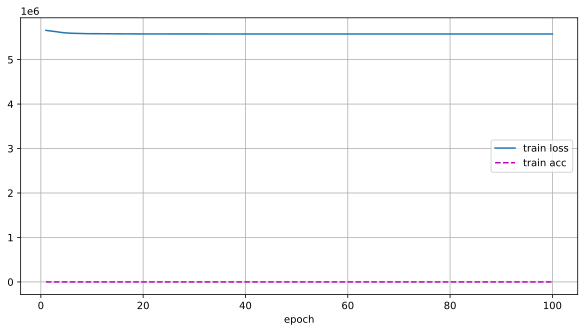

In [125]:
train(TorchLSTMNet(), data_train, epochs=100, lr=0.01)